In [5]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from myLib.dataProcess import * 
from myLib.myRegression import * 

In [6]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
# gs/lv 는 pvn_nm에 '서울특별시'로 들어와있다.
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
# 날씨에서는 지역코드로. 108=서울
w_seoul = w.loc[w['loc']==108]

# 향후 편하게 쓰기위해
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [7]:
# '아이스크림'만 빼서 df생성
item = '아이스크림'
grouped_by = 'date'

# 판매량과 날씨데이터 종합
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')

# 판매량과 소셜데이터 종합
day_gs_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

In [8]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

lv_day_w['outlier'] = pd.DataFrame(mad_based_outlier(lv_day_w['qty']))
lv_day_w = lv_day_w.loc[lv_day_w.outlier==False]

In [9]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [65]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = gs_day_w.loc[:,list_col]
target = gs_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [66]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [67]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

# 미리 편의를 위해 카테고리형(오브젝트)자료도 수치로 변환

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


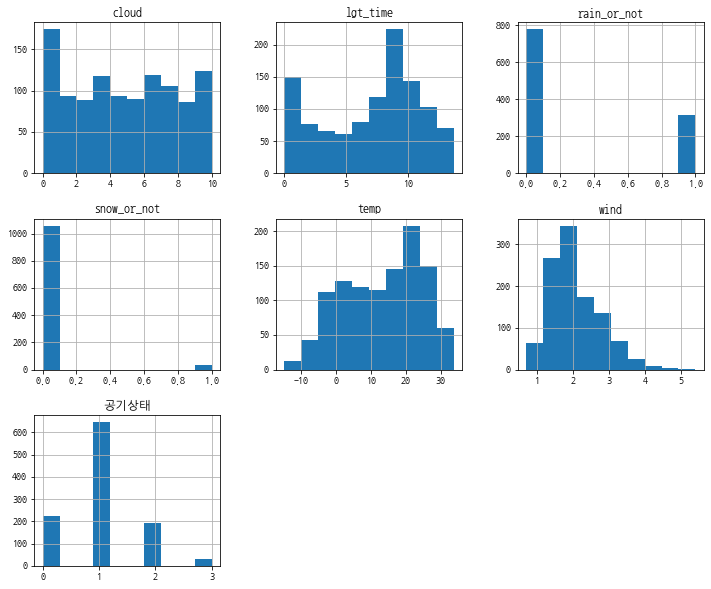

In [68]:
# seabonr패키지를 이용한 각 독립 변수의 시각화
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

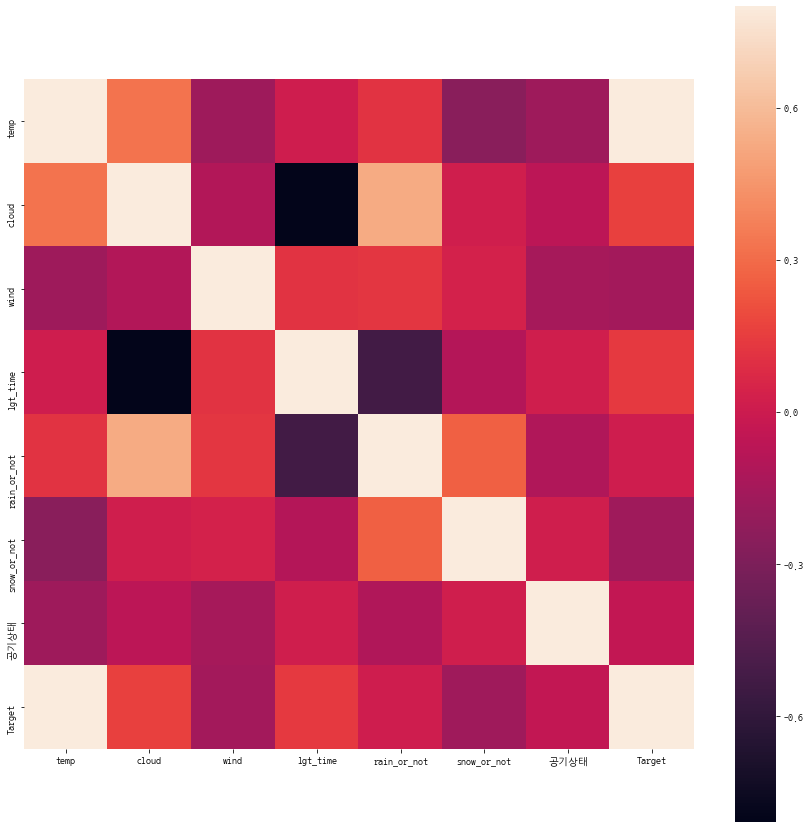

In [69]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [70]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [71]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)

In [72]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [74]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [75]:
# 신경망 모델 생성
NN_model = Sequential()

# 입력 레이어
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# 히든 레이어
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# 출력 레이어
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [76]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

# ↓weight자료가 없으면 실행↓

In [20]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0722 14:21:15.509752  1072 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 14:21:15.618458  1072 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 498us/step - loss: 21551.3594 - mean_absolute_error: 21551.3594 - val_loss: 14167.6051 - val_mean_absolute_error: 14167.6051

Epoch 00001: val_loss improved from inf to 14167.60510, saving model to 아이스크림date-Weights-001--14167.60510-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 78us/step - loss: 20911.8145 - mean_absolute_error: 20911.8145 - val_loss: 11960.1743 - val_mean_absolute_error: 11960.1743

Epoch 00002: val_loss improved from 14167.60510 to 11960.17435, saving model to 아이스크림date-Weights-002--11960.17435-cat02-vf05.hdf5
Epoch 3/1000
585/585 [==============================] - 0s 84us/step - loss: 12691.0535 - mean_absolute_error: 12691.0535 - val_loss: 9096.3688 - val_mean_absolute_error: 9096.3688

Epoch 00003: val_loss improved from 11960.17435 to 9096.36880, saving model to 아이스크림date-Weights-003--9096.36880-cat02-vf05.hdf5
Epoch 4/1000
585/585

585/585 [==============================] - 0s 78us/step - loss: 3582.1357 - mean_absolute_error: 3582.1357 - val_loss: 5697.8770 - val_mean_absolute_error: 5697.8770

Epoch 00069: val_loss did not improve from 4373.50964
Epoch 70/1000
585/585 [==============================] - 0s 80us/step - loss: 3431.5685 - mean_absolute_error: 3431.5685 - val_loss: 4794.2526 - val_mean_absolute_error: 4794.2526

Epoch 00070: val_loss did not improve from 4373.50964
Epoch 71/1000
585/585 [==============================] - 0s 77us/step - loss: 3459.1191 - mean_absolute_error: 3459.1191 - val_loss: 5065.4570 - val_mean_absolute_error: 5065.4570

Epoch 00071: val_loss did not improve from 4373.50964
Epoch 72/1000
585/585 [==============================] - 0s 78us/step - loss: 3527.1651 - mean_absolute_error: 3527.1651 - val_loss: 6111.8326 - val_mean_absolute_error: 6111.8326

Epoch 00072: val_loss did not improve from 4373.50964
Epoch 73/1000
585/585 [==============================] - 0s 77us/step - lo


Epoch 00103: val_loss did not improve from 4021.79039
Epoch 104/1000
585/585 [==============================] - 0s 73us/step - loss: 3402.3935 - mean_absolute_error: 3402.3935 - val_loss: 5379.2257 - val_mean_absolute_error: 5379.2257

Epoch 00104: val_loss did not improve from 4021.79039
Epoch 105/1000
585/585 [==============================] - 0s 77us/step - loss: 3429.4610 - mean_absolute_error: 3429.4610 - val_loss: 4042.6560 - val_mean_absolute_error: 4042.6560

Epoch 00105: val_loss did not improve from 4021.79039
Epoch 106/1000
585/585 [==============================] - 0s 80us/step - loss: 3502.5533 - mean_absolute_error: 3502.5533 - val_loss: 4259.1515 - val_mean_absolute_error: 4259.1515

Epoch 00106: val_loss did not improve from 4021.79039
Epoch 107/1000
585/585 [==============================] - 0s 73us/step - loss: 3446.3203 - mean_absolute_error: 3446.3203 - val_loss: 4811.2738 - val_mean_absolute_error: 4811.2738

Epoch 00107: val_loss did not improve from 4021.79039
E

585/585 [==============================] - 0s 84us/step - loss: 3361.2068 - mean_absolute_error: 3361.2068 - val_loss: 5508.5698 - val_mean_absolute_error: 5508.5698

Epoch 00172: val_loss did not improve from 3837.07386
Epoch 173/1000
585/585 [==============================] - 0s 84us/step - loss: 3306.6571 - mean_absolute_error: 3306.6571 - val_loss: 4956.3871 - val_mean_absolute_error: 4956.3871

Epoch 00173: val_loss did not improve from 3837.07386
Epoch 174/1000
585/585 [==============================] - 0s 84us/step - loss: 3337.7208 - mean_absolute_error: 3337.7208 - val_loss: 5186.3345 - val_mean_absolute_error: 5186.3345

Epoch 00174: val_loss did not improve from 3837.07386
Epoch 175/1000
585/585 [==============================] - 0s 82us/step - loss: 3324.2327 - mean_absolute_error: 3324.2327 - val_loss: 5378.9954 - val_mean_absolute_error: 5378.9954

Epoch 00175: val_loss did not improve from 3837.07386
Epoch 176/1000
585/585 [==============================] - 0s 78us/step 


Epoch 00206: val_loss did not improve from 3837.07386
Epoch 207/1000
585/585 [==============================] - 0s 80us/step - loss: 3500.6284 - mean_absolute_error: 3500.6284 - val_loss: 4310.3544 - val_mean_absolute_error: 4310.3544

Epoch 00207: val_loss did not improve from 3837.07386
Epoch 208/1000
585/585 [==============================] - 0s 77us/step - loss: 3358.9114 - mean_absolute_error: 3358.9114 - val_loss: 4605.6908 - val_mean_absolute_error: 4605.6908

Epoch 00208: val_loss did not improve from 3837.07386
Epoch 209/1000
585/585 [==============================] - 0s 77us/step - loss: 3288.7975 - mean_absolute_error: 3288.7975 - val_loss: 5194.6571 - val_mean_absolute_error: 5194.6571

Epoch 00209: val_loss did not improve from 3837.07386
Epoch 210/1000
585/585 [==============================] - 0s 77us/step - loss: 3295.2377 - mean_absolute_error: 3295.2377 - val_loss: 4516.8494 - val_mean_absolute_error: 4516.8494

Epoch 00210: val_loss did not improve from 3837.07386
E

585/585 [==============================] - 0s 80us/step - loss: 3204.8140 - mean_absolute_error: 3204.8140 - val_loss: 5194.8598 - val_mean_absolute_error: 5194.8598

Epoch 00276: val_loss did not improve from 3837.07386
Epoch 277/1000
585/585 [==============================] - 0s 89us/step - loss: 3213.9953 - mean_absolute_error: 3213.9953 - val_loss: 5002.5670 - val_mean_absolute_error: 5002.5670

Epoch 00277: val_loss did not improve from 3837.07386
Epoch 278/1000
585/585 [==============================] - 0s 85us/step - loss: 3212.3276 - mean_absolute_error: 3212.3276 - val_loss: 4620.4377 - val_mean_absolute_error: 4620.4377

Epoch 00278: val_loss did not improve from 3837.07386
Epoch 279/1000
585/585 [==============================] - 0s 82us/step - loss: 3224.1069 - mean_absolute_error: 3224.1069 - val_loss: 4513.2234 - val_mean_absolute_error: 4513.2234

Epoch 00279: val_loss did not improve from 3837.07386
Epoch 280/1000
585/585 [==============================] - 0s 87us/step 


Epoch 00310: val_loss did not improve from 3837.07386
Epoch 311/1000
585/585 [==============================] - 0s 94us/step - loss: 3277.1378 - mean_absolute_error: 3277.1378 - val_loss: 5095.1232 - val_mean_absolute_error: 5095.1232

Epoch 00311: val_loss did not improve from 3837.07386
Epoch 312/1000
585/585 [==============================] - 0s 99us/step - loss: 3211.7011 - mean_absolute_error: 3211.7011 - val_loss: 5201.8635 - val_mean_absolute_error: 5201.8635

Epoch 00312: val_loss did not improve from 3837.07386
Epoch 313/1000
585/585 [==============================] - 0s 99us/step - loss: 3231.7991 - mean_absolute_error: 3231.7991 - val_loss: 4629.7700 - val_mean_absolute_error: 4629.7700

Epoch 00313: val_loss did not improve from 3837.07386
Epoch 314/1000
585/585 [==============================] - 0s 92us/step - loss: 3553.7900 - mean_absolute_error: 3553.7900 - val_loss: 3682.4061 - val_mean_absolute_error: 3682.4061

Epoch 00314: val_loss improved from 3837.07386 to 3682.


Epoch 00379: val_loss did not improve from 3682.40610
Epoch 380/1000
585/585 [==============================] - 0s 97us/step - loss: 3214.9929 - mean_absolute_error: 3214.9929 - val_loss: 4525.4816 - val_mean_absolute_error: 4525.4816

Epoch 00380: val_loss did not improve from 3682.40610
Epoch 381/1000
585/585 [==============================] - 0s 97us/step - loss: 3181.6702 - mean_absolute_error: 3181.6702 - val_loss: 4526.9953 - val_mean_absolute_error: 4526.9953

Epoch 00381: val_loss did not improve from 3682.40610
Epoch 382/1000
585/585 [==============================] - 0s 104us/step - loss: 3137.4431 - mean_absolute_error: 3137.4431 - val_loss: 4750.5607 - val_mean_absolute_error: 4750.5607

Epoch 00382: val_loss did not improve from 3682.40610
Epoch 383/1000
585/585 [==============================] - 0s 116us/step - loss: 3132.3318 - mean_absolute_error: 3132.3318 - val_loss: 4625.4880 - val_mean_absolute_error: 4625.4880

Epoch 00383: val_loss did not improve from 3682.40610

585/585 [==============================] - 0s 106us/step - loss: 3154.1796 - mean_absolute_error: 3154.1796 - val_loss: 3710.7319 - val_mean_absolute_error: 3710.7319

Epoch 00448: val_loss did not improve from 3421.96947
Epoch 449/1000
585/585 [==============================] - 0s 101us/step - loss: 3154.3400 - mean_absolute_error: 3154.3400 - val_loss: 4339.4967 - val_mean_absolute_error: 4339.4967

Epoch 00449: val_loss did not improve from 3421.96947
Epoch 450/1000
585/585 [==============================] - 0s 101us/step - loss: 3055.9500 - mean_absolute_error: 3055.9500 - val_loss: 5060.7931 - val_mean_absolute_error: 5060.7931

Epoch 00450: val_loss did not improve from 3421.96947
Epoch 451/1000
585/585 [==============================] - 0s 119us/step - loss: 3082.2264 - mean_absolute_error: 3082.2264 - val_loss: 4315.6148 - val_mean_absolute_error: 4315.6148

Epoch 00451: val_loss did not improve from 3421.96947
Epoch 452/1000
585/585 [==============================] - 0s 116us/


Epoch 00482: val_loss did not improve from 3421.96947
Epoch 483/1000
585/585 [==============================] - 0s 111us/step - loss: 3051.5705 - mean_absolute_error: 3051.5705 - val_loss: 4313.6465 - val_mean_absolute_error: 4313.6465

Epoch 00483: val_loss did not improve from 3421.96947
Epoch 484/1000
585/585 [==============================] - 0s 124us/step - loss: 3058.7788 - mean_absolute_error: 3058.7788 - val_loss: 4609.8739 - val_mean_absolute_error: 4609.8739

Epoch 00484: val_loss did not improve from 3421.96947
Epoch 485/1000
585/585 [==============================] - 0s 111us/step - loss: 3053.8479 - mean_absolute_error: 3053.8479 - val_loss: 4350.2653 - val_mean_absolute_error: 4350.2653

Epoch 00485: val_loss did not improve from 3421.96947
Epoch 486/1000
585/585 [==============================] - 0s 126us/step - loss: 3089.0349 - mean_absolute_error: 3089.0349 - val_loss: 4048.5620 - val_mean_absolute_error: 4048.5620

Epoch 00486: val_loss did not improve from 3421.969


Epoch 00551: val_loss did not improve from 3421.96947
Epoch 552/1000
585/585 [==============================] - 0s 136us/step - loss: 3026.2250 - mean_absolute_error: 3026.2250 - val_loss: 4178.8342 - val_mean_absolute_error: 4178.8342

Epoch 00552: val_loss did not improve from 3421.96947
Epoch 553/1000
585/585 [==============================] - 0s 136us/step - loss: 3120.2122 - mean_absolute_error: 3120.2122 - val_loss: 5527.1887 - val_mean_absolute_error: 5527.1887

Epoch 00553: val_loss did not improve from 3421.96947
Epoch 554/1000
585/585 [==============================] - 0s 135us/step - loss: 3063.8132 - mean_absolute_error: 3063.8132 - val_loss: 4974.1119 - val_mean_absolute_error: 4974.1119

Epoch 00554: val_loss did not improve from 3421.96947
Epoch 555/1000
585/585 [==============================] - 0s 135us/step - loss: 2985.3950 - mean_absolute_error: 2985.3950 - val_loss: 4037.8510 - val_mean_absolute_error: 4037.8510

Epoch 00555: val_loss did not improve from 3421.969


Epoch 00620: val_loss did not improve from 3421.96947
Epoch 621/1000
585/585 [==============================] - 0s 123us/step - loss: 2917.1358 - mean_absolute_error: 2917.1358 - val_loss: 5109.3197 - val_mean_absolute_error: 5109.3197

Epoch 00621: val_loss did not improve from 3421.96947
Epoch 622/1000
585/585 [==============================] - 0s 133us/step - loss: 3033.9626 - mean_absolute_error: 3033.9626 - val_loss: 4784.9615 - val_mean_absolute_error: 4784.9615

Epoch 00622: val_loss did not improve from 3421.96947
Epoch 623/1000
585/585 [==============================] - 0s 133us/step - loss: 2912.0655 - mean_absolute_error: 2912.0655 - val_loss: 4865.7911 - val_mean_absolute_error: 4865.7911

Epoch 00623: val_loss did not improve from 3421.96947
Epoch 624/1000
585/585 [==============================] - 0s 136us/step - loss: 2938.7154 - mean_absolute_error: 2938.7154 - val_loss: 4614.7236 - val_mean_absolute_error: 4614.7236

Epoch 00624: val_loss did not improve from 3421.969


Epoch 00689: val_loss did not improve from 3421.96947
Epoch 690/1000
585/585 [==============================] - 0s 152us/step - loss: 2900.1302 - mean_absolute_error: 2900.1302 - val_loss: 4417.9176 - val_mean_absolute_error: 4417.9176

Epoch 00690: val_loss did not improve from 3421.96947
Epoch 691/1000
585/585 [==============================] - 0s 133us/step - loss: 3022.1683 - mean_absolute_error: 3022.1683 - val_loss: 3965.9691 - val_mean_absolute_error: 3965.9691

Epoch 00691: val_loss did not improve from 3421.96947
Epoch 692/1000
585/585 [==============================] - 0s 119us/step - loss: 3080.1748 - mean_absolute_error: 3080.1748 - val_loss: 4492.1511 - val_mean_absolute_error: 4492.1511

Epoch 00692: val_loss did not improve from 3421.96947
Epoch 693/1000
585/585 [==============================] - 0s 142us/step - loss: 3079.6967 - mean_absolute_error: 3079.6967 - val_loss: 5252.5550 - val_mean_absolute_error: 5252.5550

Epoch 00693: val_loss did not improve from 3421.969


Epoch 00758: val_loss did not improve from 3421.96947
Epoch 759/1000
585/585 [==============================] - 0s 191us/step - loss: 2852.3088 - mean_absolute_error: 2852.3088 - val_loss: 4875.8953 - val_mean_absolute_error: 4875.8953

Epoch 00759: val_loss did not improve from 3421.96947
Epoch 760/1000
585/585 [==============================] - 0s 167us/step - loss: 2907.7406 - mean_absolute_error: 2907.7406 - val_loss: 4961.0023 - val_mean_absolute_error: 4961.0023

Epoch 00760: val_loss did not improve from 3421.96947
Epoch 761/1000
585/585 [==============================] - 0s 148us/step - loss: 2872.0515 - mean_absolute_error: 2872.0515 - val_loss: 5204.9754 - val_mean_absolute_error: 5204.9754

Epoch 00761: val_loss did not improve from 3421.96947
Epoch 762/1000
585/585 [==============================] - 0s 150us/step - loss: 2915.3733 - mean_absolute_error: 2915.3733 - val_loss: 4340.0073 - val_mean_absolute_error: 4340.0073

Epoch 00762: val_loss did not improve from 3421.969


Epoch 00827: val_loss did not improve from 3421.96947
Epoch 828/1000
585/585 [==============================] - 0s 184us/step - loss: 2792.7283 - mean_absolute_error: 2792.7283 - val_loss: 4946.8362 - val_mean_absolute_error: 4946.8362

Epoch 00828: val_loss did not improve from 3421.96947
Epoch 829/1000
585/585 [==============================] - 0s 230us/step - loss: 2838.5108 - mean_absolute_error: 2838.5108 - val_loss: 5095.0388 - val_mean_absolute_error: 5095.0388

Epoch 00829: val_loss did not improve from 3421.96947
Epoch 830/1000
585/585 [==============================] - 0s 186us/step - loss: 2826.8963 - mean_absolute_error: 2826.8963 - val_loss: 4307.9642 - val_mean_absolute_error: 4307.9642

Epoch 00830: val_loss did not improve from 3421.96947
Epoch 831/1000
585/585 [==============================] - 0s 155us/step - loss: 2845.4811 - mean_absolute_error: 2845.4811 - val_loss: 4063.7174 - val_mean_absolute_error: 4063.7174

Epoch 00831: val_loss did not improve from 3421.969


Epoch 00896: val_loss did not improve from 3421.96947
Epoch 897/1000
585/585 [==============================] - 0s 191us/step - loss: 2821.6597 - mean_absolute_error: 2821.6597 - val_loss: 4128.2340 - val_mean_absolute_error: 4128.2340

Epoch 00897: val_loss did not improve from 3421.96947
Epoch 898/1000
585/585 [==============================] - 0s 182us/step - loss: 2807.8849 - mean_absolute_error: 2807.8849 - val_loss: 4717.2195 - val_mean_absolute_error: 4717.2195

Epoch 00898: val_loss did not improve from 3421.96947
Epoch 899/1000
585/585 [==============================] - 0s 293us/step - loss: 2757.2340 - mean_absolute_error: 2757.2340 - val_loss: 4715.2010 - val_mean_absolute_error: 4715.2010

Epoch 00899: val_loss did not improve from 3421.96947
Epoch 900/1000
585/585 [==============================] - 0s 297us/step - loss: 2743.3607 - mean_absolute_error: 2743.3607 - val_loss: 5130.3087 - val_mean_absolute_error: 5130.3087

Epoch 00900: val_loss did not improve from 3421.969


Epoch 00965: val_loss did not improve from 3421.96947
Epoch 966/1000
585/585 [==============================] - 0s 174us/step - loss: 2859.7735 - mean_absolute_error: 2859.7735 - val_loss: 5495.4077 - val_mean_absolute_error: 5495.4077

Epoch 00966: val_loss did not improve from 3421.96947
Epoch 967/1000
585/585 [==============================] - 0s 170us/step - loss: 2935.0441 - mean_absolute_error: 2935.0441 - val_loss: 4735.5254 - val_mean_absolute_error: 4735.5254

Epoch 00967: val_loss did not improve from 3421.96947
Epoch 968/1000
585/585 [==============================] - 0s 194us/step - loss: 2929.7579 - mean_absolute_error: 2929.7579 - val_loss: 4139.5909 - val_mean_absolute_error: 4139.5909

Epoch 00968: val_loss did not improve from 3421.96947
Epoch 969/1000
585/585 [==============================] - 0s 193us/step - loss: 2834.8563 - mean_absolute_error: 2834.8563 - val_loss: 5370.9066 - val_mean_absolute_error: 5370.9066

Epoch 00969: val_loss did not improve from 3421.969

# weight자료가 있으면 여기서 부터 실행↓

### 각 모델의 점수 확인

In [77]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '아이스크림date-Weights-425--3421.96947-cat02-vf05.hdf5' 
NN_model.load_weights(wights_file) 
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [78]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.971
검증세트점수 : 0.822
XGBoost을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.923
검증세트점수 : 0.832
LinearRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.750
검증세트점수 : 0.715
RidgeRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.741
검증세트점수 : 0.711
LassoRegression을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.750
검증세트점수 : 0.715
OLS을 이용한 아이스크림의 회귀분석 결과 :
훈련세트점수 : 0.750
검증세트점수 : 0.715


In [79]:
print(item, 'OLS Model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
# columns_in_data = 
# ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=['temp'])

# 직적 2차식으로 넣었을때 가장 높았다.
customF = 'qty ~ I(temp**2)'
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()


print(olsModel.summary())
print('직접 식을 입력한 훈련셋 점수 : {:.3f}'.format(r2_score(train_y, olsModel.predict(train_X))) )
print('직접 식을 입력한 검증셋 점수 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )

아이스크림 OLS Model
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     3151.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          4.65e-267
Time:                        16:13:15   Log-Likelihood:                -7319.7
No. Observations:                 732   AIC:                         1.464e+04
Df Residuals:                     730   BIC:                         1.465e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     8319.3278    287.8

# 각 모델을 이용하여 날짜별 예측 판매량 생산

In [80]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined['temp'])

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [81]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.22
Linear 모델 MAPE 		: 0.38
Ridge 모델 MAPE 		: 0.37
Lasso 모델 MAPE 		: 0.38
OLS 모델 MAPE 			: 0.29


In [82]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape


(1093,)

In [83]:
Xy['공기상태_3'] = Xy[["공기상태_0",'공기상태_1','공기상태_2']].sum(axis=1)
Xy['공기상태_3'] = Xy['공기상태_3'].apply(lambda x : 1 if x==0 else 0)
Xy['date'] = result_date_col

XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,date,PM10
0,15929,1.2,7.0,1.6,2.1,0,0,0,0,1,0,2016-01-01,68.6965


In [84]:
print(Xy.shape)
print(result_df.shape)

(1093, 12)
(1093, 16)


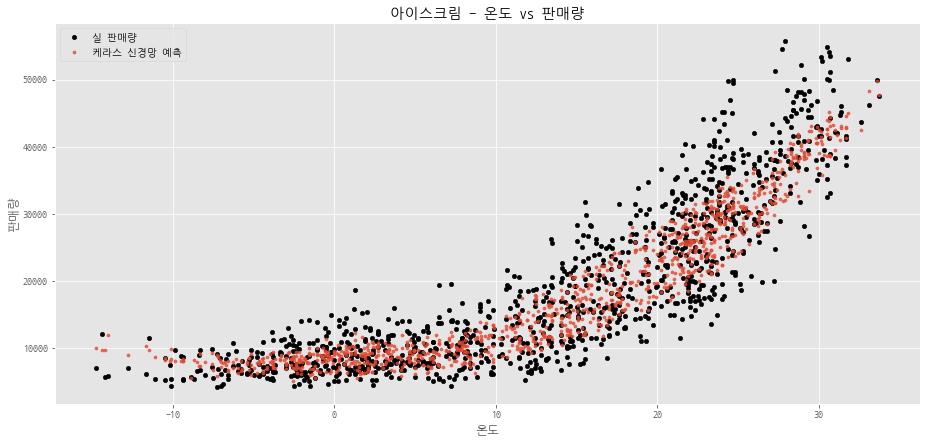

In [85]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '온도') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('온도')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
# figure_name = 'D:/project/contest/ppt/picture/%s_판매량(3년).png'%item
# plt.savefig(figure_name)
plt.show()

In [86]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

In [87]:
# # 독립변수 Xy의 col번호: 0=qty
# # ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
# #                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# # 1~11
# n=11
# # alpha 값 0~1
# alp = 0.8
# # scatter plot 점 크기
# dot_size = 10

# matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
# plt.figure(figsize=(15.5,7))
# plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

# ind = np.arange(4)
# plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
# plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# # plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# # plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# # plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# # plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# # plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# # X axis
# plt.xlabel('{}'.format(Xy.columns[n]))

# # y axis
# plt.ylabel('판매량')

# # 범례
# plt.legend()
# plt.show()

In [88]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
# print(tt)

Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,15929,10237.391602,12850.6,11611.145508,7883.349388,9164.820948,7882.683406,8376.894496,0.357311,...,0.424646,0.505136,0.474110,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,13086,10613.146484,12671.7,10829.049805,11962.546396,13165.410037,11962.107385,9618.176395,0.188969,...,0.006068,0.085885,0.265003,5.7,7.8,2.0,3.6,0,0,보통


In [89]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [90]:
def tempCat(x):
    if x < -10:
        return 0
    elif x < 0:
        return 1
    elif x < 10:
        return 2
    elif x < 20:
        return 3
    elif x < 30:
        return 4
    else:
        return 5
    
w_seoul['temp_cat'] = w_seoul.temp.apply(tempCat)
XyAndPm10 = pd.merge(result_Xy, w_seoul[['date','temp_cat']], on='date', how='left')
XyAndPm10.head()

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon,temp_cat
0,2016-01-01,15929,10237.391602,12850.6,11611.145508,7883.349388,9164.820948,7882.683406,8376.894496,0.357311,...,0.505136,0.474110,1.2,7.0,1.6,2.1,0,0,나쁨,2
1,2016-01-02,13086,10613.146484,12671.7,10829.049805,11962.546396,13165.410037,11962.107385,9618.176395,0.188969,...,0.085885,0.265003,5.7,7.8,2.0,3.6,0,0,보통,2
2,2016-01-03,14667,11215.186523,14029.3,13426.932617,13222.765421,13851.100052,13221.807911,10008.350673,0.235346,...,0.098534,0.317628,6.5,7.5,1.8,2.2,0,0,나쁨,2
3,2016-01-04,8596,7784.517090,8498.6,9865.000000,10746.597360,11669.141765,10745.795078,8479.235291,0.094402,...,0.250092,0.013584,2.0,4.4,3.1,8.6,0,0,나쁨,2
4,2016-01-05,8602,8449.025391,9554.3,9286.120117,5142.972525,6907.980438,5143.132158,8610.759202,0.017784,...,0.402100,0.001018,-2.7,3.4,2.3,7.9,0,0,보통,1


In [96]:
p_df = pd.pivot_table(XyAndPm10[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'temp_cat']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['temp_cat'],
                     aggfunc = np.sum)
p_df = p_df.iloc[:,[4,0,1,2,3,5,6,7]]
# p_df

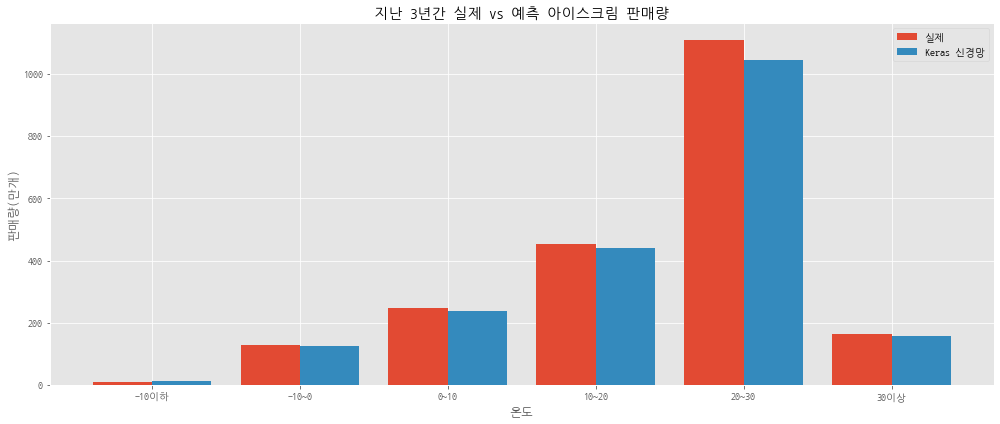

In [95]:
# 8개 판매량
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty/10000, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty/10000, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('지난 3년간 실제 vs 예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량(만개)')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(('-10이하','-10~0','0~10','10~20','20~30','30이상'))
ax.set_xlabel('온도')

# 범례
ax.legend()

fig.tight_layout()
# figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
# plt.savefig(figure_name)
plt.show()